In [2]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 16.2MB/s 
     |████████████████████████████████| 51kB 8.3MB/s 
     |████████████████████████████████| 194kB 57.9MB/s 
     |████████████████████████████████| 1.2MB 60.2MB/s 
     |████████████████████████████████| 61kB 11.0MB/s 
Mounted at /content/gdrive


In [4]:
#hide
from fastbook import *

**bold text**# Other Computer Vision Problems

##Replicate full lab for multi-label classification

### Prepare data loaders

In [63]:
from fastai.vision.all import *
path = untar_data(URLs.PASCAL_2007)

In [49]:
df=pd.read_csv(path/'train.csv')

In [56]:
def get_fname(r):
  return path /'train' / r['fname']
get_fname(df.iloc[0])

Path('/root/.fastai/data/pascal_2007/train/000005.jpg')

In [58]:
def get_labels(r):
  return r['labels'].split(' ')
get_labels(df.iloc[1])
get_labels(df.iloc[2])

['horse', 'person']

In [75]:
def split_train_val(df):
  val=df.index[df['is_valid']==True].tolist()
  train=df.index[~df['is_valid']==True].tolist()
  return train,val

In [77]:
dblock=DataBlock(blocks=(ImageBlock,MultiCategoryBlock),get_x=get_fname,get_y=get_labels,
                 splitter=split_train_val,
                 item_tfms=RandomResizedCrop(128, min_scale=0.35) )
dsets=dblock.datasets(df)
dsets

(#5011) [(PILImage mode=RGB size=500x375, TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])),(PILImage mode=RGB size=500x333, TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])),(PILImage mode=RGB size=500x375, TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.])),(PILImage mode=RGB size=500x333, TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])),(PILImage mode=RGB size=334x500, TensorMultiCategory([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])),(PILImage mode=RGB size=480x364, TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.])),(PILImage mode=RGB size=500x375, TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])),(PILImage mode=RGB size=375x500, Tensor

In [78]:
dls =dblock.dataloaders(df)
dls.train_ds,dls.valid_ds

((#2501) [(PILImage mode=RGB size=500x333, TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])),(PILImage mode=RGB size=480x364, TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.])),(PILImage mode=RGB size=334x500, TensorMultiCategory([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])),(PILImage mode=RGB size=500x333, TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])),(PILImage mode=RGB size=500x281, TensorMultiCategory([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])),(PILImage mode=RGB size=500x366, TensorMultiCategory([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])),(PILImage mode=RGB size=360x500, TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])),(PILImage mode=RGB size=500x375, Tenso

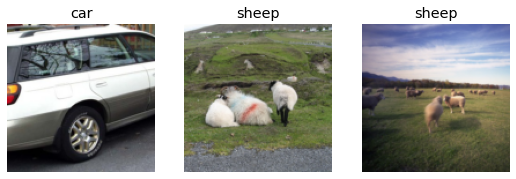

In [79]:
dls.show_batch(nrows=1, ncols=3)

### construct the model

In [80]:
learn=cnn_learner(dls,resnet18,metrics=partial(accuracy_multi,thresh=0.2))
learn.fine_tune(3,base_lr=3e-3,freeze_epochs=4)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.998550,0.733308,0.196633,00:26
1,0.876703,0.574354,0.233147,00:26
2,0.643941,0.216752,0.805179,00:26
3,0.392196,0.144737,0.933426,00:26


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.156325,0.130874,0.937948,00:26
1,0.138755,0.121450,0.941414,00:26
2,0.122092,0.119738,0.943366,00:26


In [81]:
learn50=cnn_learner(dls,resnet50,metrics=partial(accuracy_multi,thresh=0.2))
learn50.fine_tune(3,base_lr=3e-3,freeze_epochs=4)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.940218,0.688979,0.236454,00:28
1,0.822476,0.558268,0.285219,00:28
2,0.601101,0.203078,0.820179,00:28
3,0.358273,0.127804,0.942550,00:28


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.133171,0.116978,0.942231,00:29
1,0.116124,0.107627,0.948785,00:29
2,0.096749,0.102722,0.952410,00:29


## Multi-Label Classification

### The Data

In [4]:
from fastai.vision.all import *
path = untar_data(URLs.PASCAL_2007)

In [5]:
df = pd.read_csv(path/'train.csv')
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


### Sidebar: Pandas and DataFrames

In [ ]:
df.iloc[:,0]

0       000005.jpg
1       000007.jpg
2       000009.jpg
3       000012.jpg
4       000016.jpg
           ...    
5006    009954.jpg
5007    009955.jpg
5008    009958.jpg
5009    009959.jpg
5010    009961.jpg
Name: fname, Length: 5011, dtype: object

In [ ]:
df.iloc[0,:]
# Trailing :s are always optional (in numpy, pytorch, pandas, etc.),
#   so this is equivalent:
df.iloc[0]

fname       000005.jpg
labels           chair
is_valid          True
Name: 0, dtype: object

In [ ]:
df['fname']

0       000005.jpg
1       000007.jpg
2       000009.jpg
3       000012.jpg
4       000016.jpg
           ...    
5006    009954.jpg
5007    009955.jpg
5008    009958.jpg
5009    009959.jpg
5010    009961.jpg
Name: fname, Length: 5011, dtype: object

In [ ]:
tmp_df = pd.DataFrame({'a':[1,2], 'b':[3,4]})
tmp_df

,a,b
0,1,3
1,2,4


In [ ]:
tmp_df['c'] = tmp_df['a']+tmp_df['b']
tmp_df

,a,b,c
0,1,3,4
1,2,4,6


### End sidebar

### Constructing a DataBlock

In [ ]:
dblock = DataBlock()

In [ ]:
df

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True
...,...,...,...
5006,009954.jpg,horse person,True
5007,009955.jpg,boat,True
5008,009958.jpg,person bicycle,True
5009,009959.jpg,car,False


In [ ]:
dsets = dblock.datasets(df)

In [ ]:
len(dsets.train),len(dsets.valid)

(4009, 1002)

In [ ]:
dsets.train

(#4009) [(fname       008663.jpg
labels      car person
is_valid         False
Name: 4346, dtype: object, fname       008663.jpg
labels      car person
is_valid         False
Name: 4346, dtype: object),(fname       003497.jpg
labels           train
is_valid         False
Name: 1763, dtype: object, fname       003497.jpg
labels           train
is_valid         False
Name: 1763, dtype: object),(fname       003133.jpg
labels       aeroplane
is_valid         False
Name: 1576, dtype: object, fname       003133.jpg
labels       aeroplane
is_valid         False
Name: 1576, dtype: object),(fname       006367.jpg
labels            bird
is_valid         False
Name: 3209, dtype: object, fname       006367.jpg
labels            bird
is_valid         False
Name: 3209, dtype: object),(fname       008837.jpg
labels       tvmonitor
is_valid          True
Name: 4431, dtype: object, fname       008837.jpg
labels       tvmonitor
is_valid          True
Name: 4431, dtype: object),(fname       006218.jpg
la

In [ ]:
x,y = dsets.train[0]
x,y

(fname       008663.jpg
 labels      car person
 is_valid         False
 Name: 4346, dtype: object, fname       008663.jpg
 labels      car person
 is_valid         False
 Name: 4346, dtype: object)

In [ ]:
dblock = DataBlock(get_x = lambda r: r['fname'], get_y = lambda r: r['labels'])
dsets = dblock.datasets(df)
dsets.train[0]

('005620.jpg', 'aeroplane')

In [ ]:
def get_x(r): return r['fname']
def get_y(r): return r['labels']
dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

('002549.jpg', 'tvmonitor')

In [ ]:
def get_x(r): return path/'train'/r['fname']
def get_y(r): return r['labels'].split(' ')
dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(Path('/root/.fastai/data/pascal_2007/train/002844.jpg'), ['train'])

In [6]:
path

Path('/root/.fastai/data/pascal_2007')

In [7]:
def get_x(r):
  return path /'train' /r['fname']
def get_y(r):
  return r['labels'].split(' ')


Start Lab

In [9]:
dblock=DataBlock(get_x=get_x,get_y=get_y)

In [12]:
dsets=dblock.datasets(df)

In [13]:
dsets.train[0]

(Path('/root/.fastai/data/pascal_2007/train/002549.jpg'), ['tvmonitor'])

End lab

In [ ]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x375,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [ ]:
torch.where(dsets.train[0][1]==1.)[0]

TensorMultiCategory([11])

In [ ]:
idxs = torch.where(dsets.train[0][1]==1.)[0]
dsets.train.vocab[idxs]

(#1) ['dog']

In [ ]:
len(dsets.train)

4009

In [15]:
def splitter(df):
    train = df.index[~df['is_valid']].tolist()
    valid = df.index[df['is_valid']].tolist()
    return train,valid

dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x, 
                   get_y=get_y)

dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x333,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [16]:
len(dsets.train)

2501

In [17]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x, 
                   get_y=get_y,
                   item_tfms = RandomResizedCrop(128, min_scale=0.35))
dls = dblock.dataloaders(df)

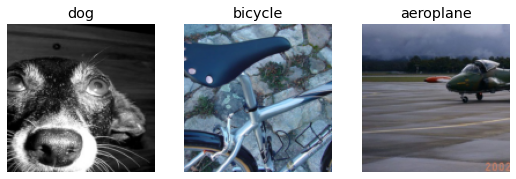

In [18]:
dls.show_batch(nrows=1, ncols=3)

### Binary Cross-Entropy

In [19]:
learn = cnn_learner(dls, resnet18)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [20]:
x,y = to_cpu(dls.train.one_batch())
activs = learn.model(x)
activs.shape

torch.Size([64, 20])

In [21]:
activs[0]

tensor([ 0.1689,  0.2438,  1.1909, -3.5800, -1.4893,  2.9633,  1.2128, -1.7251, -1.9491, -0.2050, -2.6291,  1.9258,  1.2319, -0.4684,  3.2763,  2.1802, -1.1874,  2.8831, -1.4362, -1.0289],
       grad_fn=<SelectBackward>)

Start lab - try understand what is binary cross entropy

In [26]:
torch.where(y[0]==1,0.2,0.7)

TensorMultiCategory([0.7000, 0.7000, 0.7000, 0.7000, 0.7000, 0.7000, 0.7000, 0.2000, 0.7000, 0.7000, 0.7000, 0.7000, 0.7000, 0.7000, 0.7000, 0.7000, 0.7000, 0.7000, 0.7000, 0.7000])

In [29]:
torch.where(y[1]==1,0.2,0.7)

TensorMultiCategory([0.7000, 0.7000, 0.7000, 0.7000, 0.7000, 0.7000, 0.7000, 0.7000, 0.2000, 0.7000, 0.7000, 0.7000, 0.7000, 0.7000, 0.2000, 0.7000, 0.7000, 0.7000, 0.7000, 0.7000])

In [33]:
torch.where(y[0:2]==1,0.2,0.7).log()

TensorMultiCategory([[-0.3567, -0.3567, -0.3567, -0.3567, -0.3567, -0.3567, -0.3567, -1.6094, -0.3567, -0.3567, -0.3567, -0.3567, -0.3567, -0.3567, -0.3567, -0.3567, -0.3567, -0.3567, -0.3567, -0.3567],
        [-0.3567, -0.3567, -0.3567, -0.3567, -0.3567, -0.3567, -0.3567, -0.3567, -1.6094, -0.3567, -0.3567, -0.3567, -0.3567, -0.3567, -1.6094, -0.3567, -0.3567, -0.3567, -0.3567, -0.3567]])

In [35]:
def binary_cross_entropy(inputs, targets):
    inputs = inputs.sigmoid()
    return -torch.where(targets==1, inputs, 1-inputs).log().mean()

In [36]:
binary_cross_entropy(activs,y)

TensorMultiCategory(1.0333, grad_fn=<AliasBackward>)

End lab - try understand what is binary cross entropy


In [34]:
def binary_cross_entropy(inputs, targets):
    inputs = inputs.sigmoid()
    return -torch.where(targets==1, inputs, 1-inputs).log().mean()

In [37]:
loss_func = nn.BCEWithLogitsLoss()
loss = loss_func(activs, y)
loss

TensorMultiCategory(1.0333, grad_fn=<AliasBackward>)

In [38]:
def say_hello(name, say_what="Hello"): return f"{say_what} {name}."
say_hello('Jeremy'),say_hello('Jeremy', 'Ahoy!')

('Hello Jeremy.', 'Ahoy! Jeremy.')

In [39]:
f = partial(say_hello, say_what="Bonjour")
f("Jeremy"),f("Sylvain")

('Bonjour Jeremy.', 'Bonjour Sylvain.')

In [40]:
learn = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.2))
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.944073,0.704048,0.229104,00:28
1,0.824539,0.545896,0.300100,00:28
2,0.602933,0.200853,0.824004,00:28
3,0.360953,0.126798,0.942271,00:28


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.135711,0.120715,0.939402,00:29
1,0.117231,0.109436,0.948646,00:29
2,0.098513,0.106400,0.948805,00:29


In [41]:
learn.metrics = partial(accuracy_multi, thresh=0.1)
learn.validate()

(#2) [0.10640014708042145,0.9258766770362854]

In [42]:
learn.metrics = partial(accuracy_multi, thresh=0.99)
learn.validate()

(#2) [0.10640014708042145,0.944103479385376]

In [43]:
preds,targs = learn.get_preds()

In [44]:
??accuracy_multi

In [45]:
accuracy_multi(preds, targs, thresh=0.9, sigmoid=False)

TensorBase(0.9569)

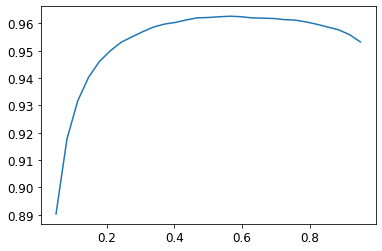

In [46]:
xs = torch.linspace(0.05,0.95,29)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs,accs);

## Replicate full lab for regression


### Prepare data loader

In [5]:
path=untar_data(URLs.BIWI_HEAD_POSE)

In [8]:
Path.BASE_PATH=path

In [57]:
(path/'13').ls().sorted()

(#972) [Path('13/depth.cal'),Path('13/frame_00003_pose.txt'),Path('13/frame_00003_rgb.jpg'),Path('13/frame_00004_pose.txt'),Path('13/frame_00004_rgb.jpg'),Path('13/frame_00005_pose.txt'),Path('13/frame_00005_rgb.jpg'),Path('13/frame_00006_pose.txt'),Path('13/frame_00006_rgb.jpg'),Path('13/frame_00007_pose.txt')...]

In [13]:
imgfiles=get_image_files(path)

In [19]:
imgfiles[0]

Path('14/frame_00725_rgb.jpg')

In [26]:
def img2pos(img_file):
  return Path(f'{str(img_file)[:-7]}pose.txt')
img2pos(imgfiles[0])

Path('14/frame_00725_pose.txt')

In [30]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)
def get_ctr(f):
    ctr = np.genfromtxt(img2pos(f), skip_header=3)
    c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
    c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
    return tensor([c1,c2])

In [32]:
get_ctr(imgfiles[0])

tensor([344.1029, 219.1128])

In [63]:
dblock=DataBlock(blocks=(ImageBlock,PointBlock),
    get_items=get_image_files,
                 splitter=FuncSplitter(lambda img_file_path:img_file_path.parent.name=='13' ),
          get_y=get_ctr,
    batch_tfms=[*aug_transforms(size=(240,320)), 
                Normalize.from_stats(*imagenet_stats)])

In [64]:
dsets=dblock.datasets(path)

In [65]:
dsets.valid

(#485) [(PILImage mode=RGB size=640x480, TensorPoint([[356.4215, 261.8052]])),(PILImage mode=RGB size=640x480, TensorPoint([[359.3781, 235.9004]])),(PILImage mode=RGB size=640x480, TensorPoint([[367.7313, 244.4980]])),(PILImage mode=RGB size=640x480, TensorPoint([[381.3871, 229.9070]])),(PILImage mode=RGB size=640x480, TensorPoint([[342.8136, 235.9904]])),(PILImage mode=RGB size=640x480, TensorPoint([[356.8766, 228.5919]])),(PILImage mode=RGB size=640x480, TensorPoint([[331.8733, 258.8803]])),(PILImage mode=RGB size=640x480, TensorPoint([[341.3530, 222.6932]])),(PILImage mode=RGB size=640x480, TensorPoint([[308.3918, 247.1350]])),(PILImage mode=RGB size=640x480, TensorPoint([[376.6342, 238.2206]]))...]

In [66]:
dls=dblock.dataloaders(path)

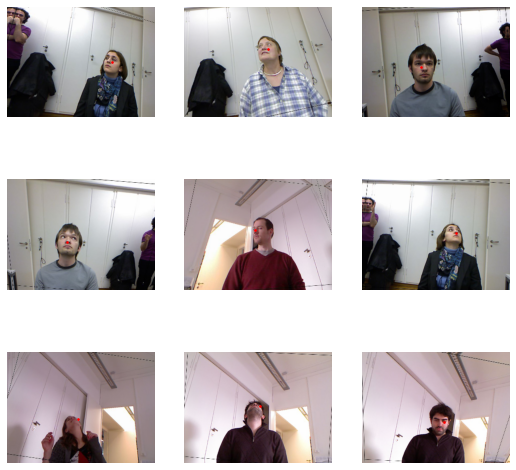

In [67]:
dls.show_batch()

### Training the model

In [68]:
reg_learner=cnn_learner(dls,resnet18,metrics=rmse,y_range=(-1,1))
reg_learner.fine_tune(3,1e-2)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


epoch,train_loss,valid_loss,_rmse,time
0,0.047950,0.020092,0.141747,02:05


epoch,train_loss,valid_loss,_rmse,time
0,0.007646,0.005248,0.072443,02:17
1,0.003246,0.000114,0.010663,02:15
2,0.001486,0.000074,0.008631,02:17


## Regression

### Assemble the Data

In [3]:
path = untar_data(URLs.BIWI_HEAD_POSE)

In [4]:
#hide
Path.BASE_PATH = path

In [5]:
path.ls().sorted()

(#50) [Path('01'),Path('01.obj'),Path('02'),Path('02.obj'),Path('03'),Path('03.obj'),Path('04'),Path('04.obj'),Path('05'),Path('05.obj')...]

In [6]:
(path/'01').ls().sorted()

(#1000) [Path('01/depth.cal'),Path('01/frame_00003_pose.txt'),Path('01/frame_00003_rgb.jpg'),Path('01/frame_00004_pose.txt'),Path('01/frame_00004_rgb.jpg'),Path('01/frame_00005_pose.txt'),Path('01/frame_00005_rgb.jpg'),Path('01/frame_00006_pose.txt'),Path('01/frame_00006_rgb.jpg'),Path('01/frame_00007_pose.txt')...]

In [7]:
img_files = get_image_files(path)
def img2pose(x): return Path(f'{str(x)[:-7]}pose.txt')
img2pose(img_files[0])

Path('14/frame_00725_pose.txt')

In [8]:
im = PILImage.create(img_files[0])
im.shape

(480, 640)

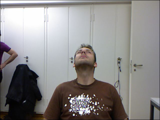

In [9]:
im.to_thumb(160)

In [10]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)
def get_ctr(f):
    ctr = np.genfromtxt(img2pose(f), skip_header=3)
    c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
    c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
    return tensor([c1,c2])

In [11]:
get_ctr(img_files[0])

tensor([344.1029, 219.1128])

In [12]:
biwi = DataBlock(
    blocks=(ImageBlock, PointBlock),
    get_items=get_image_files,
    get_y=get_ctr,
    splitter=FuncSplitter(lambda o: o.parent.name=='13'),
    batch_tfms=[*aug_transforms(size=(240,320)), 
                Normalize.from_stats(*imagenet_stats)]
)

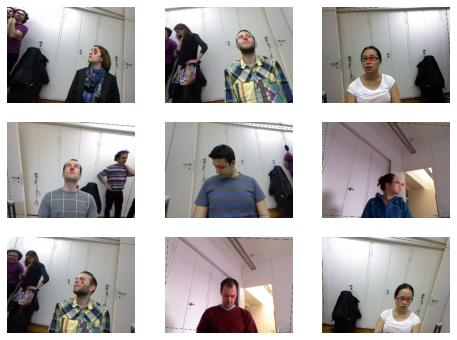

In [13]:
dls = biwi.dataloaders(path)
dls.show_batch(max_n=9, figsize=(8,6))

In [14]:
xb,yb = dls.one_batch()
xb.shape,yb.shape

((64, 3, 240, 320), (64, 1, 2))

In [15]:
yb[0]

TensorPoint([[-0.1312, -0.0990]], device='cuda:0')

### Training a Model

In [16]:
learn = cnn_learner(dls, resnet18, y_range=(-1,1))

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [17]:
def sigmoid_range(x, lo, hi): return torch.sigmoid(x) * (hi-lo) + lo

/usr/local/lib/python3.6/dist-packages/fastbook/__init__.py:73: UserWarning: Not providing a value for linspace's steps is deprecated and will throw a runtime error in a future release. This warning will appear only once per process. (Triggered internally at  /pytorch/aten/src/ATen/native/RangeFactories.cpp:23.)
  x = torch.linspace(min,max)


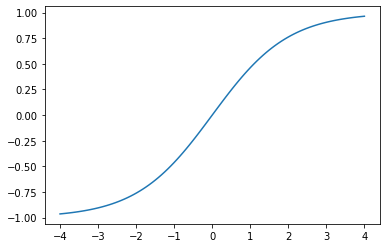

In [18]:
plot_function(partial(sigmoid_range,lo=-1,hi=1), min=-4, max=4)

In [19]:
dls.loss_func

FlattenedLoss of MSELoss()

SuggestedLRs(lr_min=0.00831763744354248, lr_steep=5.754399353463668e-06)

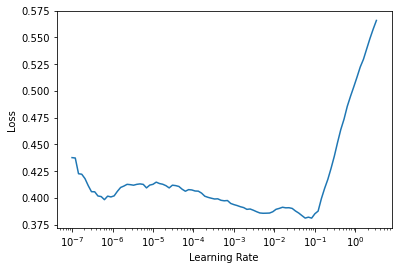

In [20]:
learn.lr_find()

In [21]:
lr = 1e-2
learn.fine_tune(3, lr)

epoch,train_loss,valid_loss,time
0,0.049913,0.018140,02:00


epoch,train_loss,valid_loss,time
0,0.007915,0.005336,02:10
1,0.003067,0.000201,02:10
2,0.001476,0.000516,02:12


In [22]:
math.sqrt(0.0001)

0.01

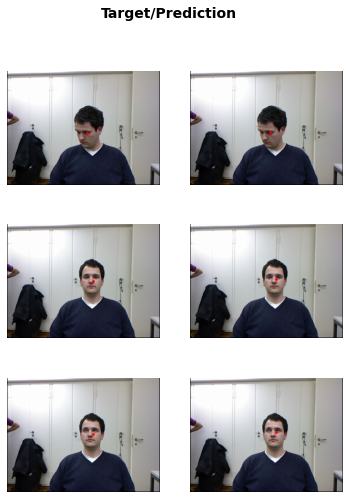

In [23]:
learn.show_results(ds_idx=1, nrows=3, figsize=(6,8))

## Conclusion

## Questionnaire

1. How could multi-label classification improve the usability of the bear classifier?
1. How do we encode the dependent variable in a multi-label classification problem?
1. How do you access the rows and columns of a DataFrame as if it was a matrix?
1. How do you get a column by name from a DataFrame?
1. What is the difference between a `Dataset` and `DataLoader`?
1. What does a `Datasets` object normally contain?
1. What does a `DataLoaders` object normally contain?
1. What does `lambda` do in Python?
1. What are the methods to customize how the independent and dependent variables are created with the data block API?
1. Why is softmax not an appropriate output activation function when using a one hot encoded target?
1. Why is `nll_loss` not an appropriate loss function when using a one-hot-encoded target?
1. What is the difference between `nn.BCELoss` and `nn.BCEWithLogitsLoss`?
1. Why can't we use regular accuracy in a multi-label problem?
1. When is it okay to tune a hyperparameter on the validation set?
1. How is `y_range` implemented in fastai? (See if you can implement it yourself and test it without peeking!)
1. What is a regression problem? What loss function should you use for such a problem?
1. What do you need to do to make sure the fastai library applies the same data augmentation to your inputs images and your target point coordinates?

### Further Research

1. Read a tutorial about Pandas DataFrames and experiment with a few methods that look interesting to you. See the book's website for recommended tutorials.
1. Retrain the bear classifier using multi-label classification. See if you can make it work effectively with images that don't contain any bears, including showing that information in the web application. Try an image with two different kinds of bears. Check whether the accuracy on the single-label dataset is impacted using multi-label classification.